In [15]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [16]:
eta_0 = np.load('./data/eta.npy')
eta_0 = eta_0
eta_0.shape

(64, 64, 64, 3)

In [17]:
def compute_gradient_3d(phi, dx=1.0, dy=1.0, dz=1.0, periodic=False):
    grad_x = (torch.roll(phi, -1, dims=0) - torch.roll(phi, 1, dims=0)) / (2 * dx)
    grad_y = (torch.roll(phi, -1, dims=1) - torch.roll(phi, 1, dims=1)) / (2 * dy)
    grad_z = (torch.roll(phi, -1, dims=2) - torch.roll(phi, 1, dims=2)) / (2 * dz)
    
    if not periodic:
        grad_x[0, :, :] = (phi[1, :, :] - phi[0, :, :]) / dx
        grad_x[-1, :, :] = (phi[-1, :, :] - phi[-2, :, :]) / dx
        grad_y[:, 0, :] = (phi[:, 1, :] - phi[:, 0, :]) / dy
        grad_y[:, -1, :] = (phi[:, -1, :] - phi[:, -2, :]) / dy
        grad_z[:, :, 0] = (phi[:, :, 1] - phi[:, :, 0]) / dz
        grad_z[:, :, -1] = (phi[:, :, -1] - phi[:, :, -2]) / dz
    
    return torch.stack([grad_x, grad_y, grad_z], dim = -1)

Iteration 500, Loss: 0.004356318153440952
Iteration 1000, Loss: 0.004350306466221809
Iteration 1500, Loss: 0.004331009928137064
Iteration 2000, Loss: 0.004332204815000296
Iteration 2500, Loss: 0.004328932147473097


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77299273..1.0012989].


Iteration 3000, Loss: 0.004328435752540827


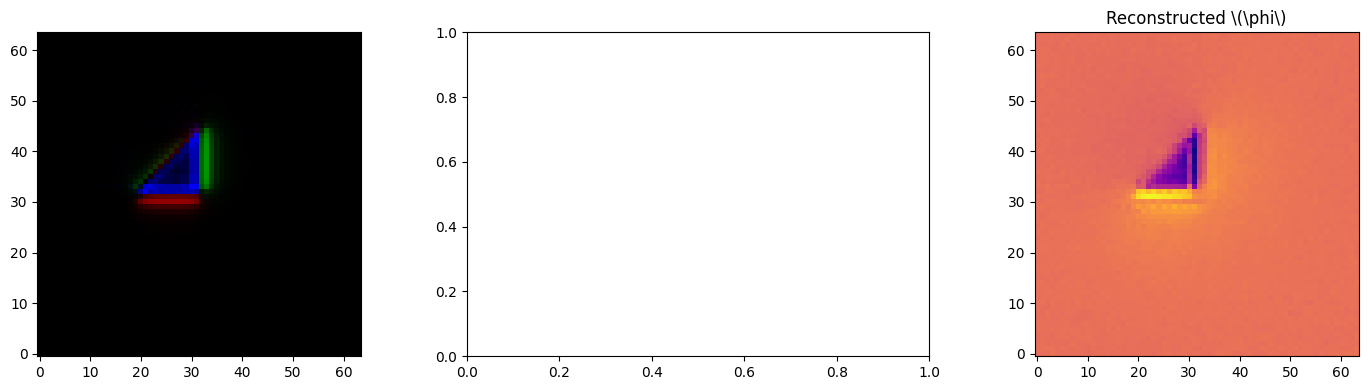

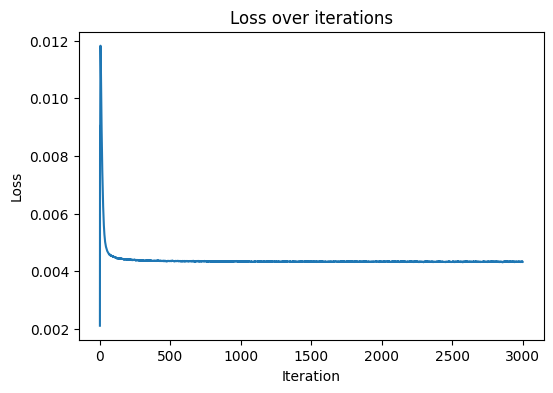

In [18]:
# Parameters
N = eta_0.shape[0]
dx = dy = dz = 1.0 / N
num_iterations = 3000
learning_rate = 0.001

# Create a variable phi on the same grid.
phi = torch.zeros((N, N, N), dtype=torch.float32, requires_grad=True)

# Set up the optimizer.
optimizer = optim.Adam([phi], lr=learning_rate)

loss_history = []

eta_0_torch = torch.tensor(eta_0, dtype=torch.float32)

# Optimization loop.
for i in range(num_iterations):
    optimizer.zero_grad()

    grad_phi = compute_gradient_3d(phi, dx = dx, dy = dy, dz = dz, periodic=True)
    # Compute the L1 loss to approximate the mass norm.
    loss = torch.abs(grad_phi - eta_0_torch).mean()
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if (i + 1) % 500 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item()}")

# Retrieve the optimized phi.
phi_opt = phi.detach().cpu().numpy()

# Visualize the results.
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].imshow(eta_0_torch.detach().cpu().numpy()[:, :, N // 2 + 1], origin='lower')

ax[2].imshow(phi_opt[:, :, N // 2 + 1], origin='lower', cmap='plasma')
ax[2].set_title("Reconstructed \\(\\phi\\)")
plt.tight_layout()
plt.show()

# Plot the loss history.
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


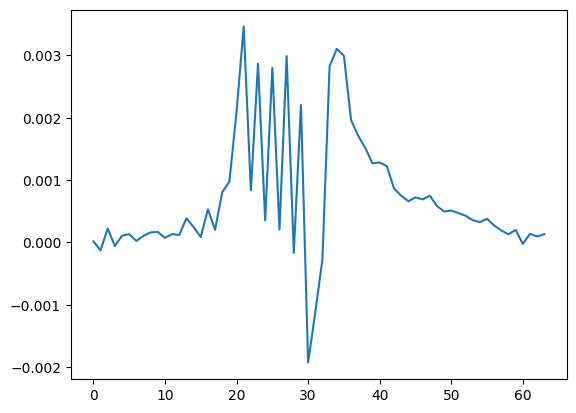

In [19]:
plt.plot(phi_opt[N // 2, :, N // 2])